In [1]:
import logging
import os

import numpy as np
from keras import metrics, Sequential
from keras.src.layers import Dropout

import pandas as pd
import tensorflow as tf
from keras import Input, Model
from keras.src import regularizers
from keras.src.callbacks import ReduceLROnPlateau
from keras.src.layers import Dense, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from keras.src.optimizers import Adam, SGD
import time
from keras import models
from keras.src.callbacks import ModelCheckpoint, TensorBoard

from keras.src.callbacks import EarlyStopping
pd.options.mode.chained_assignment = None  # default='warn'


2023-12-16 22:11:14.786601: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-16 22:11:14.786639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-16 22:11:14.787871: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-16 22:11:14.793846: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-16 22:11:15.478953: W tensorflow/compiler/tf2

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"

2023-12-16 22:11:16.044386: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-16 22:11:16.082982: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-16 22:11:16.083253: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Genetic Disorder 73.5% accuracy (3 classes)

In [3]:
from sklearn.preprocessing import MinMaxScaler

file_path = 'dataset/train.csv'
data = pd.read_csv(file_path)


features_used = ['Inherited from father', 'Maternal gene', 'Paternal gene', 'Genes in mother\'s side', 'Symptom 1',
                 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5',
                 # 'H/O radiation exposure (x-ray)',
                 # 'Gender',
                 # 'Blood test result',
                 ]
targets = ['Genetic Disorder', 'Disorder Subclass']

dataset = data.loc[:, features_used + targets].dropna(subset=['Genetic Disorder', 'Disorder Subclass'], how='all')
# Fill missing values in 'Genetic Disorder' based on 'Disorder Subclass'
subclass_to_disorder = {
    'Leber\'s hereditary optic neuropathy': 'Mitochondrial genetic inheritance disorders',
    'Leigh syndrome': 'Mitochondrial genetic inheritance disorders',
    'Mitochondrial myopathy': 'Mitochondrial genetic inheritance disorders',
    'Alzheimer\'s': 'Multifactorial genetic inheritance disorders',
    'Cancer': 'Multifactorial genetic inheritance disorders',
    'Diabetes': 'Multifactorial genetic inheritance disorders',
    'Cystic fibrosis': 'Single-gene inheritance diseases',
    'Hemochromatosis': 'Single-gene inheritance diseases',
    'Tay-Sachs': 'Single-gene inheritance diseases',
}

dataset['Genetic Disorder'] = dataset.apply(
    lambda row: subclass_to_disorder[row['Disorder Subclass']]
    if pd.isna(row['Genetic Disorder']) else row['Genetic Disorder'],
    axis=1
)

# dataset = dataset.dropna(subset=['Disorder Subclass'], how='all')
dataset = dataset.drop(['Disorder Subclass'], axis=1)

# CATEGORIAL BINARY
dataset["Genes in mother's side"] = dataset["Genes in mother's side"].replace({'Yes': 1.0, 'No': 0.0})
dataset['Inherited from father'] = dataset['Inherited from father'].replace({'No': 0.0, 'Yes': 1.0})
dataset['Maternal gene'] = dataset['Maternal gene'].replace({'No': 0.0, 'Yes': 1.0})
dataset["Paternal gene"] = dataset["Paternal gene"].replace({'Yes': 1.0, 'No': 0.0})
# dataset['H/O radiation exposure (x-ray)'] = dataset['H/O radiation exposure (x-ray)'].replace({'No': 0.0, '-': 2, 'Not applicable': 3, 'Yes': 1.0})
# dataset['Gender'] = dataset['Gender'].replace({'Male': 1.0, 'Female': 0.0, 'Ambiguous': 2.0})
# dataset['Blood test result'] = dataset['Blood test result'].replace({'normal': 0.0, 'inconclusive': -1, 'slightly abnormal': 1, 'abnormal': 2})


# dataset = dataset.dropna(subset=['Symptom 4', 'Symptom 5'])
#-------------------------------------------------------%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--------------------------------#

Epoch 1/25


2023-12-16 21:45:42.773428: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-16 21:45:42.773708: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-16 21:45:42.773915: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

188/188 [==============================] - 3s 7ms/step - loss: 0.9656 - accuracy: 0.4884 - precision: 0.5191 - mean_squared_error: 0.1970 - recall: 0.2565 - val_loss: 0.9021 - val_accuracy: 0.5060 - val_precision: 0.5622 - val_mean_squared_error: 0.1875 - val_recall: 0.2560 - lr: 0.0100
Epoch 2/25
188/188 [==============================] - 1s 6ms/step - loss: 0.9064 - accuracy: 0.5069 - precision: 0.5593 - mean_squared_error: 0.1889 - recall: 0.3225 - val_loss: 0.8636 - val_accuracy: 0.5107 - val_precision: 0.5929 - val_mean_squared_error: 0.1827 - val_recall: 0.3787 - lr: 0.0100
Epoch 3/25
188/188 [==============================] - 1s 6ms/step - loss: 0.8828 - accuracy: 0.5209 - precision: 0.5761 - mean_squared_error: 0.1855 - recall: 0.3763 - val_loss: 0.8468 - val_accuracy: 0.5187 - val_precision: 0.6082 - val_mean_squared_error: 0.1811 - val_recall: 0.4047 - lr: 0.0100
Epoch 4/25
188/188 [==============================] - 1s 6ms/step - loss: 0.8658 - accuracy: 0.5313 - precision: 0

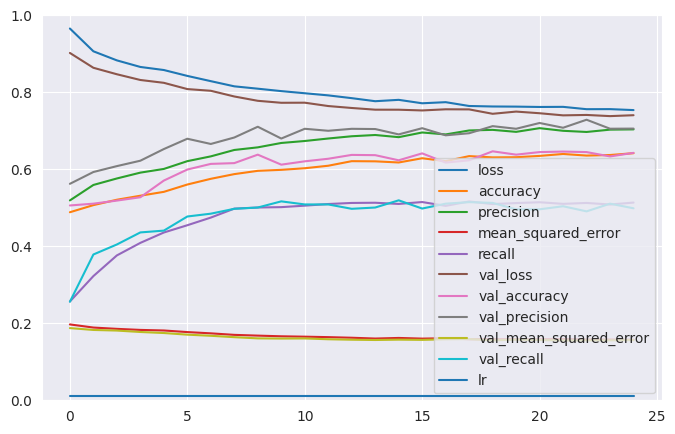

In [4]:
nn_data_1 = dataset.dropna()

# MAP TARGET COLUMNS TO ONE-HOT CODED ARRAYS
genetic_disorder_mapping = {
    'Mitochondrial genetic inheritance disorders': [1, 0, 0],
    'Multifactorial genetic inheritance disorders': [0, 1, 0],
    'Single-gene inheritance diseases': [0, 0, 1]
}
nn_data_1.loc[:, "Genetic Disorder"] = nn_data_1['Genetic Disorder'].map(genetic_disorder_mapping)


# DROP SUBCLASS NaN AND SUBCLASS


# SHUFFLE AND SPLIT DATASET
nn_data_1.sample(frac=1)

validation_set = nn_data_1[0:1500]
test_set = nn_data_1[1500:3000]
train_set = nn_data_1[3000:]

# DROP SUBCLASS NaN AND SUBCLASS


y_train_genetic = np.array(list(train_set['Genetic Disorder']))
y_test_genetic = np.array(list(test_set['Genetic Disorder']))
y_val_genetic = np.array(list(validation_set['Genetic Disorder']))

X_train = train_set.drop(['Genetic Disorder'], axis=1)
X_test = test_set.drop(['Genetic Disorder'], axis=1)
X_val = validation_set.drop(['Genetic Disorder'], axis=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
checkpoint_cb = ModelCheckpoint("my_model", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=15, restore_best_weights=True)



model = Sequential()
model.add(Dense(128, input_dim=9, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
# model.add(Dense(12, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax',
                       name='genetic_output',
                       kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.L2(1e-4),
                        activity_regularizer=regularizers.L2(1e-5)))

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd, 
              loss={'genetic_output': 'categorical_crossentropy'}, 
              metrics=['accuracy', metrics.Precision(), metrics.MeanSquaredError(), metrics.Recall()])


history = model.fit(X_train, {'genetic_output': y_train_genetic}, epochs=30, batch_size=50,
                    validation_data=(X_val, y_val_genetic),
                    callbacks=[reduce_lr, checkpoint_cb, early_stopping_cb])


 # EVALUATE MODEL
score = model.evaluate(X_test, {'genetic_output': y_test_genetic}, batch_size=30)
print(score)
print()
print("Accuracy: ", score[1])
print("Precision: ", score[2])
print("Recall: ", score[4])
print("F1 score: ", (score[2]*score[4]*2) / (score[2]+score[4]))
print("Mean squarred error: ", score[3])


# PLOT EVALUATION
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

# Genetic Disorder 73.5% accuracy (2 classes)

Epoch 1/25
353/353 [==============================] - 2s 3ms/step - loss: 0.6771 - accuracy: 0.5835 - precision_26: 0.5838 - mean_squared_error: 0.2420 - recall_26: 0.5786 - val_loss: 0.6645 - val_accuracy: 0.5960 - val_precision_26: 0.5958 - val_mean_squared_error: 0.2359 - val_recall_26: 0.5910
Epoch 2/25
353/353 [==============================] - 1s 3ms/step - loss: 0.6387 - accuracy: 0.6485 - precision_26: 0.6477 - mean_squared_error: 0.2238 - recall_26: 0.6449 - val_loss: 0.6165 - val_accuracy: 0.6625 - val_precision_26: 0.6620 - val_mean_squared_error: 0.2140 - val_recall_26: 0.6610
Epoch 3/25
353/353 [==============================] - 1s 3ms/step - loss: 0.6060 - accuracy: 0.6797 - precision_26: 0.6791 - mean_squared_error: 0.2089 - recall_26: 0.6784 - val_loss: 0.6020 - val_accuracy: 0.6830 - val_precision_26: 0.6863 - val_mean_squared_error: 0.2066 - val_recall_26: 0.6805
Epoch 4/25
353/353 [==============================] - 1s 3ms/step - loss: 0.5916 - accuracy: 0.6941 - prec

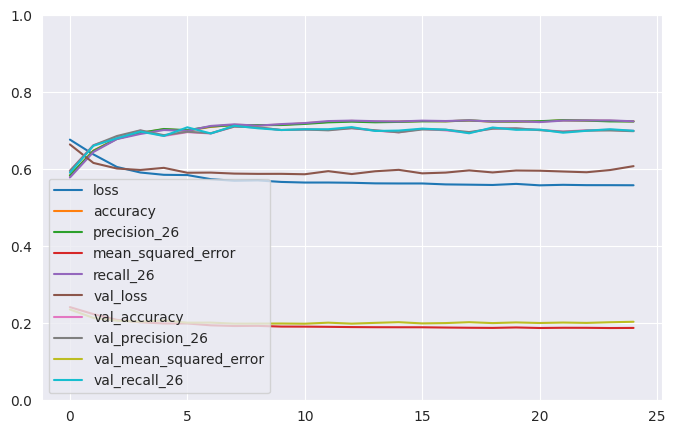

In [31]:
nn_data_2 = dataset.copy()
nn_data_2 = nn_data_2.loc[dataset['Genetic Disorder'] != 'Multifactorial genetic inheritance disorders']
nn_data_2 = nn_data_2.dropna()

# MAP TARGET COLUMNS TO ONE-HOT CODED ARRAYS
genetic_disorder_mapping = {
    'Mitochondrial genetic inheritance disorders': [1, 0],
    'Single-gene inheritance diseases': [0, 1]
}
nn_data_2['Genetic Disorder'] = nn_data_2['Genetic Disorder'].map(genetic_disorder_mapping)



# SHUFFLE AND SPLIT DATASET
nn_data_2.sample(frac=1)

validation_set = nn_data_2[0:2000]
test_set = nn_data_2[2000:4000]
train_set = nn_data_2[4000:]

# DROP SUBCLASS NaN AND SUBCLASS


y_train_genetic = np.array(list(train_set['Genetic Disorder']))
y_test_genetic = np.array(list(test_set['Genetic Disorder']))
y_val_genetic = np.array(list(validation_set['Genetic Disorder']))

X_train = train_set.drop(['Genetic Disorder'], axis=1)
X_test = test_set.drop(['Genetic Disorder'], axis=1)
X_val = validation_set.drop(['Genetic Disorder'], axis=1)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
# early_stopping_cb = EarlyStopping(patience=15, restore_best_weights=True)


model = Sequential()
model.add(Dense(128, input_dim=9, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(2, activation='sigmoid',
                       name='genetic_output',
                       # kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                       #  bias_regularizer=regularizers.L2(1e-4),
                       #  activity_regularizer=regularizers.L2(1e-5))
                ))


model.compile(optimizer='rmsprop', 
              loss={'genetic_output': 'binary_crossentropy'}, 
              metrics=['accuracy', metrics.Precision(), metrics.MeanSquaredError(), metrics.Recall()])


history = model.fit(X_train, {'genetic_output': y_train_genetic}, epochs=25, batch_size=20,
                    validation_data=(X_val, y_val_genetic),
                    # callbacks=[early_stopping_cb]
                    )


 # EVALUATE MODEL
score = model.evaluate(X_test, {'genetic_output': y_test_genetic}, batch_size=20)
print(score)
print()
print("Accuracy: ", score[1])
print("Precision: ", score[2])
print("Recall: ", score[4])
print("F1 score: ", (score[2]*score[4]*2) / (score[2]+score[4]))
print("Mean squarred error: ", score[3])


# PLOT EVALUATION
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

Epoch 1/50


2023-12-16 22:11:23.171675: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-16 22:11:23.171958: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-16 22:11:23.172160: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

256/256 [==============================] - 3s 5ms/step - loss: 1.7647 - accuracy: 0.2871 - precision: 0.3824 - mean_squared_error: 0.0886 - recall: 0.0051 - val_loss: 1.4853 - val_accuracy: 0.3885 - val_precision: 0.0000e+00 - val_mean_squared_error: 0.0808 - val_recall: 0.0000e+00 - lr: 0.0100
Epoch 2/50
256/256 [==============================] - 1s 4ms/step - loss: 1.4630 - accuracy: 0.3671 - precision: 0.3755 - mean_squared_error: 0.0808 - recall: 0.0232 - val_loss: 1.3329 - val_accuracy: 0.4205 - val_precision: 0.0000e+00 - val_mean_squared_error: 0.0766 - val_recall: 0.0000e+00 - lr: 0.0100
Epoch 3/50
256/256 [==============================] - 1s 3ms/step - loss: 1.3753 - accuracy: 0.3996 - precision: 0.4434 - mean_squared_error: 0.0782 - recall: 0.0430 - val_loss: 1.2915 - val_accuracy: 0.4225 - val_precision: 0.4798 - val_mean_squared_error: 0.0753 - val_recall: 0.1070 - lr: 0.0100
Epoch 4/50
256/256 [==============================] - 1s 3ms/step - loss: 1.3494 - accuracy: 0.406

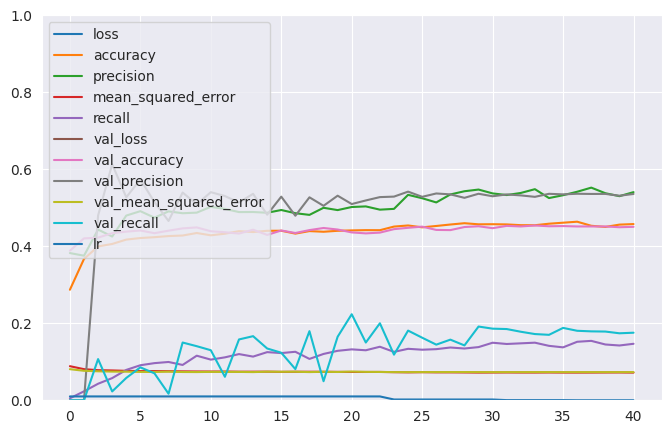

In [3]:

file_path = 'dataset/train.csv'
data = pd.read_csv(file_path)


features_used = ['Inherited from father', 'Maternal gene', 'Paternal gene', 'Genes in mother\'s side', 'Symptom 1',
                 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5',
                 # 'H/O radiation exposure (x-ray)',
                 # 'Gender',
                 # 'Blood test result',
                 ]
targets = ['Genetic Disorder', 'Disorder Subclass']

dataset = data.loc[:, features_used + targets].dropna(subset=['Genetic Disorder', 'Disorder Subclass'], how='all')
# Fill missing values in 'Genetic Disorder' based on 'Disorder Subclass'
subclass_to_disorder = {
    'Leber\'s hereditary optic neuropathy': 'Mitochondrial genetic inheritance disorders',
    'Leigh syndrome': 'Mitochondrial genetic inheritance disorders',
    'Mitochondrial myopathy': 'Mitochondrial genetic inheritance disorders',
    'Alzheimer\'s': 'Multifactorial genetic inheritance disorders',
    'Cancer': 'Multifactorial genetic inheritance disorders',
    'Diabetes': 'Multifactorial genetic inheritance disorders',
    'Cystic fibrosis': 'Single-gene inheritance diseases',
    'Hemochromatosis': 'Single-gene inheritance diseases',
    'Tay-Sachs': 'Single-gene inheritance diseases',
}

dataset['Genetic Disorder'] = dataset.apply(
    lambda row: subclass_to_disorder[row['Disorder Subclass']]
    if pd.isna(row['Genetic Disorder']) else row['Genetic Disorder'],
    axis=1
)

# dataset = dataset.dropna(subset=['Disorder Subclass'], how='all')
# dataset = dataset.drop(['Disorder Subclass'], axis=1)

# CATEGORIAL BINARY
dataset["Genes in mother's side"] = dataset["Genes in mother's side"].replace({'Yes': 1.0, 'No': 0.0})
dataset['Inherited from father'] = dataset['Inherited from father'].replace({'No': 0.0, 'Yes': 1.0})
dataset['Maternal gene'] = dataset['Maternal gene'].replace({'No': 0.0, 'Yes': 1.0})
dataset["Paternal gene"] = dataset["Paternal gene"].replace({'Yes': 1.0, 'No': 0.0})
# dataset['H/O radiation exposure (x-ray)'] = dataset['H/O radiation exposure (x-ray)'].replace({'No': 0.0, '-': 2, 'Not applicable': 3, 'Yes': 1.0})
# dataset['Gender'] = dataset['Gender'].replace({'Male': 1.0, 'Female': 0.0, 'Ambiguous': 2.0})
# dataset['Blood test result'] = dataset['Blood test result'].replace({'normal': 0.0, 'inconclusive': -1, 'slightly abnormal': 1, 'abnormal': 2})


nn_data_4 = dataset.dropna().drop(['Genetic Disorder'], axis=1)


# MAP TARGET COLUMNS TO ONE-HOT CODED ARRAYS
disorder_subclass_mapping = {
    "Leber's hereditary optic neuropathy": [1, 0, 0, 0, 0, 0, 0, 0, 0],  
    'Cystic fibrosis': [0, 1, 0, 0, 0, 0, 0, 0, 0],
    'Diabetes': [0, 0, 1, 0, 0, 0, 0, 0, 0],
    'Leigh syndrome': [0, 0, 0, 1, 0, 0, 0, 0, 0],
    'Tay-Sachs': [0, 0, 0, 0, 1, 0, 0, 0, 0],  
    'Mitochondrial myopathy': [0, 0, 0, 0, 0, 1, 0, 0, 0],
    'Hemochromatosis': [0, 0, 0, 0, 0, 0, 1, 0, 0],
    "Alzheimer's": [0, 0, 0, 0, 0, 0, 0, 1, 0],
    'Cancer': [0, 0, 0, 0, 0, 0, 0, 0, 1]  
}

nn_data_4['Disorder Subclass'] = nn_data_4['Disorder Subclass'].map(disorder_subclass_mapping)


# SHUFFLE AND SPLIT DATASET
nn_data_4.sample(frac=1)

validation_set = nn_data_4[0:2000]
test_set = nn_data_4[2000:4000]
train_set = nn_data_4[4000:]

# DROP SUBCLASS NaN AND SUBCLASS


y_train_genetic = np.array(list(train_set['Disorder Subclass']))
y_test_genetic = np.array(list(test_set['Disorder Subclass']))
y_val_genetic = np.array(list(validation_set['Disorder Subclass']))

X_train = train_set.drop(['Disorder Subclass'], axis=1)
X_test = test_set.drop(['Disorder Subclass'], axis=1)
X_val = validation_set.drop(['Disorder Subclass'], axis=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
checkpoint_cb = ModelCheckpoint("my_model", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=15, restore_best_weights=True)



model = Sequential()
model.add(Dense(128, input_dim=9, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax',
                       name='genetic_output',
                       kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.L2(1e-4),
                        activity_regularizer=regularizers.L2(1e-5)))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd, 
              loss={'genetic_output': 'categorical_crossentropy'}, 
              metrics=['accuracy', metrics.Precision(), metrics.MeanSquaredError(), metrics.Recall()])


history = model.fit(X_train, {'genetic_output': y_train_genetic}, epochs=50, batch_size=30,
                    validation_data=(X_val, y_val_genetic),
                    callbacks=[reduce_lr, checkpoint_cb, early_stopping_cb])


 # EVALUATE MODEL


67/67 [==============================] - 0s 1ms/step - loss: 1.1764 - accuracy: 0.4445 - precision: 0.5338 - mean_squared_error: 0.0718 - recall: 0.1540
[1.1763802766799927, 0.44449999928474426, 0.5337954759597778, 0.07183375954627991, 0.15399999916553497]

Accuracy:  0.44449999928474426
Precision:  0.5337954759597778
Recall:  0.15399999916553497
F1 score:  0.23903763785998997
Mean squarred error:  0.07183375954627991


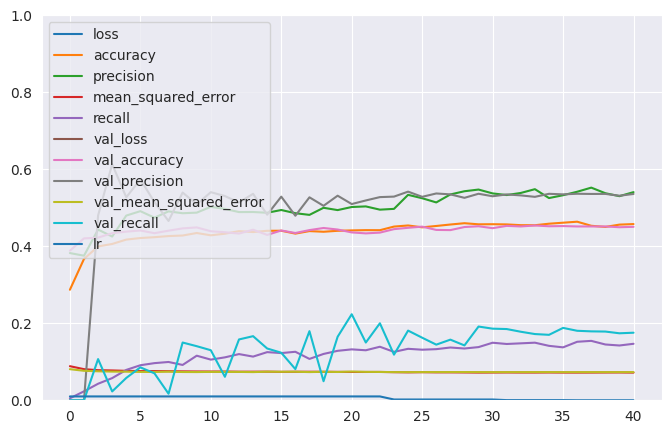

In [4]:
score = model.evaluate(X_test, {'genetic_output': y_test_genetic}, batch_size=30)
print(score)
print()
print("Accuracy: ", score[1])
print("Precision: ", score[2])
print("Recall: ", score[4])
print("F1 score: ", (score[2]*score[4]*2) / (score[2]+score[4]))
print("Mean squarred error: ", score[3])


# PLOT EVALUATION
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()